In [1]:
import autograd.numpy as np
import autograd as ag
from scipy.misc import factorial

from keras.models import Model
from keras.layers import Input, Dense, Lambda, Reshape, ActivityRegularization, Activation, Flatten, Concatenate, Multiply
from keras.optimizers import Adam, SGD
from keras import optimizers
import keras.backend as K
from keras.utils import to_categorical
from keras import losses
import tensorflow as tf
from keras import losses

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [6]:
from galton import n_nails 
from galton import n_rows
theta_0 = -0.8
theta_1 = -0.6

# Density estimation with histograms

In [16]:
samples_0, _, scores_0, _ = galton_rvs(theta_0, n_runs=10000, random_state=1234)
p_estimated_0, _ = np.histogram(samples_0, bins=n_nails, range=(0, n_nails), density=True)

samples_1, _, scores_1, _ = galton_rvs(theta_1, n_runs=10000, random_state=1234)
p_estimated_1, _ = np.histogram(samples_1, bins=n_nails, range=(0, n_nails), density=True)

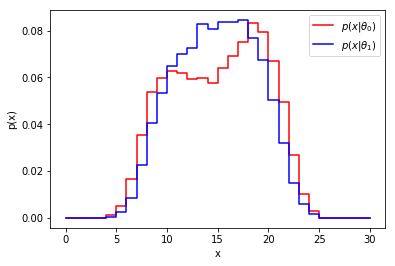

In [22]:
plt.step(range(len(p_estimated_0)), p_estimated_0,
         c='r', lw=1.5,
         label=r'$p(x|\theta_0)$')
plt.step(range(len(p_estimated_0)), p_estimated_1,
         c='b', lw=1.5, 
         label=r'$p(x|\theta_1)$')

plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend()
plt.show()

/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


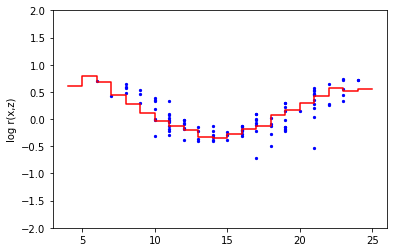

In [23]:
plt.step(range(len(p_estimated_0)), np.log(p_estimated_0/p_estimated_1),
         c='r', lw=1.5,
         label=r'$p(x|\theta_0)$')
plt.scatter(samples, np.array(log_p0) - np.array(log_p1), s=5., c='b')
plt.ylabel('log r(x,z)')
plt.ylim(-2.,2.)
plt.show()

# Model comparison

In [30]:
n_features = 1
hidden_size = 10
n_outputs = n_nails

In [31]:
from collections import Counter
from itertools import zip_longest
def groupers(iterables, n, fillvalues=None):
    result = []
    for k, iterable in enumerate(iterables):
        args = [iter(iterable)] * n
        result.append(zip_longest(*args, fillvalue=fillvalues[k]))
    return result

In [37]:
def score_loss(y_true, y_pred): return losses.mean_squared_error(y_true, y_pred[:,-1])
def simple_loss(y_true, y_pred): return losses.categorical_crossentropy(y_true, y_pred[:,:-1])
def combined_loss(y_true, y_pred, alpha=1.):
    loss = (losses.categorical_crossentropy(y_true[:,:-1], y_pred[:,:-1]) 
            + alpha * losses.mean_squared_error(y_true[:,-1], y_pred[:,-1]))
    return loss

def make_score_regressor(mode='loss', lr=0.0001):
    ''' mode: loss, score, comb '''
    adam = Adam(lr=lr)
    input_layer = Input(shape=(n_features,))
    out_index_layer = Input(shape=(n_outputs, ))
    hidden_layer = Dense(hidden_size, activation='tanh')(input_layer)
    log_hat_layer = Dense(n_outputs, activation='softmax')(hidden_layer)
    #log_sum_layer = Lambda(lambda x: K.sum(x, axis=1), output_shape=(1, ))(log_hat_layer)
    log_sum_layer = Lambda(lambda x: tf.reduce_sum(tf.multiply(x[0],x[1]),
                                               axis=1,keep_dims=True))([out_index_layer, log_hat_layer])
    log_sum_layer = Lambda(lambda x: K.log(x))(log_sum_layer)
    gradient_layer = Lambda(lambda x: K.gradients(x[0],[x[1]])[0],
                           output_shape=(n_features,))([log_sum_layer, input_layer])
    #log_sum_layer = Lambda(lambda x: tf.einsum('ij, ij->i', x[0], x[1]))([out_index_layer, out_index_layer])
    #log_sum_layer_inv = Lambda(lambda x: 1./x, output_shape=(1, ))(log_sum_layer)
    #score_layer = Multiply()([gradient_layer, log_sum_layer_inv])

    #score_layer = Lambda(lambda x: tf.divide(x[0],[1]), 
    #                     output_shape=(1,))([gradient_layer, log_sum_layer])
    score_layer = gradient_layer
    output_layer = Concatenate()([log_hat_layer, score_layer])

    model = Model(inputs=[input_layer, out_index_layer], outputs=[output_layer])
    if mode == 'loss':
        loss = simple_loss
    elif mode == 'score':
        loss = score_loss
    else: #combined
        loss = combined_loss    
    model.compile(loss=loss, metrics=['mse'], optimizer=adam)
    return model

In [38]:
p_ratio = np.divide(p_estimated_1, p_estimated_0)

p_ratio[np.isinf(p_ratio)] = 0.
p_ratio[np.isnan(p_ratio)] = 0.

def gen_data(num_data, n_thetas = 10, state = 0):
    theta_values = np.linspace(-1.,-0.4,n_thetas)
    #theta_values = np.random.uniform(-1,1,n_thetas)
    n_traces_per_theta = num_data
    thetas = []
    X = []
    T = []
    for k, theta_ in enumerate(theta_values):
        x, _, scores, _ = galton_rvs(theta_, random_state=state+k, n_runs=n_traces_per_theta)
        X += x
        T += scores.tolist()
        thetas += (theta_*np.ones(n_traces_per_theta)).tolist()
    train_data = np.array(thetas).reshape((len(X), 1))
    labels = np.array(X).reshape((len(X), 1))
    labels = to_categorical(labels, num_classes=n_nails)

    return train_data, labels, T

/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/autograd-1.2-py3.6.egg/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in true_divide
  return f_raw(*args, **kwargs)


In [51]:
EPOCHS = 50
BATCH_SIZE = 16
N_data = 100

In [52]:
def compute_mse(p_train, p_estimated):
    p_ratio_train =  np.log(p_train[0]) - np.log(p_train[1])
    p_ratio = np.log(p_estimated[0]) - np.log(p_estimated[1])
    mse = p_ratio_train - p_ratio
    mse[np.isinf(mse)] = 0.
    mse[np.isnan(mse)] = 0.
    mse = np.dot(mse**2, p_estimated[1])
    return mse

def mse_ratio(ratio, p_estimated, log=True):
    p_ratio = np.log(p_estimated[0]) - np.log(p_estimated[1])
    if log:
        p_ratio_train = np.log(ratio)
    else:
        p_ratio_train = ratio
    mse = p_ratio_train - p_ratio
    mse[np.isinf(mse)] = 0.
    mse[np.isnan(mse)] = 0.
    mse = np.dot(mse**2, p_estimated[1])
    return mse

In [59]:
mse = []
mse_scandal = []
mse_carl = []
mse_rolr = []
p_estimated = np.array([p_estimated_0, p_estimated_1])

samples_size = [100,200] #,500,1000,2000,5000,10000]

print('Start training')

for n in samples_size:

    print('Samples: {0}'.format(n))

    train_data, labels, T = gen_data(n)
    model = make_score_regressor(mode='loss', lr=0.0001)
    model_scandal = make_score_regressor(mode='combined', lr=0.0001)
    choices = np.random.choice(len(train_data), len(train_data), replace=False)
    train_data_c = train_data[choices]
    labels_c = labels[choices]
    scores_c = np.array(T)[choices]
    scores_c = scores_c.reshape((len(scores_c), 1))
    for k in range(EPOCHS):

        for b, batch in enumerate(zip(*groupers([train_data_c, scores_c, labels_c], 
                                           BATCH_SIZE, fillvalues=[train_data_c[-1],
                                                                   scores_c[-1], labels_c[-1]]))):
            train_batch, score_batch, label_batch = batch
            train_batch, score_batch, label_batch = np.array(train_batch), np.array(score_batch), np.array(label_batch)
            output_batch = np.hstack([label_batch, score_batch.reshape((BATCH_SIZE,1)),])
            print(output_batch.shape)
            l = model.train_on_batch([train_batch, label_batch], output_batch)   # gilles this cannot work
            l_scandal = model_scandal.train_on_batch([train_batch, label_batch], 
                            output_batch)

    p_train = model.predict([theta_test, np.zeros((len(theta_test), n_outputs))])[:,:-1]
    p_train_scandal = model_scandal.predict([theta_test, np.zeros((len(theta_test), n_outputs))])[:,:-1]


    # CARL
    samples_0, scores_0 = plinko.rvs(true_b, true_c, theta_0, 1, n_runs=n)
    samples_1, scores_1 = plinko.rvs(true_b, true_c, theta_1, 1, n_runs=n)        
    train_data_0 = np.array(samples_0).reshape((len(samples_0),1))
    train_data_1 = np.array(samples_1).reshape((len(samples_1),1))
    ratio_clf = make_ratio(train_data_0, train_data_1)
    ratio_carl = ratio_clf.predict(np.array(range(n_nails)).reshape((n_nails,1)))[0]

    samples, scores_0_0, scores_1_0, log_p0, log_p1 = plinko.rvs_ratio(true_b, true_c, 
                                                                   theta_0, theta_1, 1,
                                                                   n_runs=n)
    log_ratio_0 = np.array(log_p0) - np.array(log_p1)
    samples_0 = np.array(samples).reshape((len(samples),1))

    samples, scores_1_1, scores_0_1, log_p1, log_p0 = plinko.rvs_ratio(true_b, true_c, 
                                                                   theta_1, theta_0, 1,
                                                                   n_runs=n)
    log_ratio_1 = np.array(log_p0) - np.array(log_p1)
    samples_1 = np.array(samples).reshape((len(samples),1))

    samples = np.vstack((samples_0, samples_1))
    log_ratios = np.hstack((log_ratio_0, log_ratio_1))
    scores = np.hstack((scores_0_0, scores_0_1))

    y = np.zeros(len(samples), dtype=np.int)
    y[-len(samples_0):] = 1
    y = y.reshape((len(y),1))
    y = np.hstack((y.reshape(-1, 1), log_ratios.reshape((-1, 1)), scores.reshape((-1, 1))))
    thetas = (theta_0 * np.ones(len(samples), dtype='float32')).reshape((len(samples), 1))

    rolr_clf = make_ratio_rolr(samples, thetas, y)
    ratio_rolr = rolr_clf.predict(np.hstack((np.array(range(n_nails)).reshape((n_nails,1)),
                                       (theta_0 * np.ones(n_nails, dtype='float32')
                                                        ).reshape((n_nails, 1)))))[:,1]


    mse.append(compute_mse(p_train, p_estimated))
    mse_scandal.append(compute_mse(p_train_comb, p_estimated))
    mse_carl.append(mse_ratio(ratio_carl[7:25], p_estimated[:,7:25]))
    mse_rolr.append(mse_ratio(ratio_rolr[5:25], p_estimated[:,5:25], log=False))

Start training
Samples: 100
(16, 32)


InvalidArgumentError: Incompatible shapes: [16,32] vs. [16,31]
	 [[Node: loss_20/concatenate_21_loss/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_concatenate_21_target_0, loss_20/concatenate_21_loss/Log)]]

Caused by op 'loss_20/concatenate_21_loss/mul', defined at:
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-59-e5b1ec084257>", line 16, in <module>
    model = make_score_regressor(mode='loss', lr=0.0001)
  File "<ipython-input-37-7ca579898993>", line 37, in make_score_regressor
    model.compile(loss=loss, metrics=['mse'], optimizer=adam)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/keras/engine/training.py", line 830, in compile
    sample_weight, mask)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/keras/engine/training.py", line 429, in weighted
    score_array = fn(y_true, y_pred)
  File "<ipython-input-37-7ca579898993>", line 2, in simple_loss
    def simple_loss(y_true, y_pred): return losses.categorical_crossentropy(y_true, y_pred[:,:-1])
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/keras/losses.py", line 69, in categorical_crossentropy
    return K.categorical_crossentropy(y_true, y_pred)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3008, in categorical_crossentropy
    return - tf.reduce_sum(target * tf.log(output),
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 821, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1044, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1434, in _mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [16,32] vs. [16,31]
	 [[Node: loss_20/concatenate_21_loss/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_concatenate_21_target_0, loss_20/concatenate_21_loss/Log)]]
